<a href="https://colab.research.google.com/github/AbdallahAwdalla/DRL_Contrast_Enhancement-/blob/main/DRL_Adaptive_Contrast_SB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DRL-Based Adaptive Contrast Enhancement (PyTorch + Stable-Baselines3)

This notebook reimplements the adaptive contrast enhancement agent **without TensorFlow**.
It uses:
- **PyTorch** + **torchvision** (pretrained CNN features)
- **Gymnasium** environment
- **Stable-Baselines3 (DQN)** for reinforcement learning
- **OpenCV** for CLAHE actions
- **scikit-image** for metrics (**PSNR**, **SSIM**) and demo images

**Idea:** The agent observes a feature vector of the current grayscale image (extracted with a frozen pretrained CNN),
then chooses a CLAHE(Contrast Limited Adaptive Histogram Equalization) clipLimit or `STOP`. Reward is the change in **EME** (Enhancement Measure Estimation).

> Tip: Start with the built-in sample images to verify the pipeline, then switch to a folder that contains COCO images.


In [2]:

# If running in Colab or a fresh environment, uncomment:
%pip -q install "torch>=2.2" "torchvision>=0.17" "gymnasium>=0.29" "stable-baselines3[extra]>=2.3.2" \
                    opencv-python scikit-image matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.9 MB/s eta 0:00:00


In [3]:

import os, glob, math, random, time, pathlib
from typing import List, Optional

import numpy as np
import cv2
from skimage import io as skio
from skimage import data as skdata
from skimage import img_as_ubyte
from skimage import metrics

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env

SEED = 0
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch device:", DEVICE)


Torch device: cuda


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
# === COCO 2017 downloader + loader (no TensorFlow) ===
import os, shutil, zipfile, urllib.request
from pathlib import Path
from typing import Optional

# Where to put COCO on disk
COCO_ROOT = Path("./coco2017").resolve()
COCO_ROOT.mkdir(parents=True, exist_ok=True)

# Official image zips
COCO_URLS = {
    "train": "http://images.cocodataset.org/zips/train2017.zip",
    "val":   "http://images.cocodataset.org/zips/val2017.zip",
}

def _download(url: str, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    if dst.exists():
        print(f"[skip] {dst.name} already exists")
        return
    print(f"[download] {url} -> {dst}")
    def _progress(count, block_size, total_size):
        pct = int(count * block_size * 100 / max(total_size, 1))
        print(f"\r  {pct:3d}% ({count*block_size/1e6:.1f}MB/{total_size/1e6:.1f}MB)", end="")
    urllib.request.urlretrieve(url, dst.as_posix(), reporthook=_progress)
    print("\n  done.")

def _extract(zip_path: Path, out_dir: Path, expect_folder: str):
    out_dir.mkdir(parents=True, exist_ok=True)
    marker = out_dir / expect_folder
    if marker.exists() and any(marker.iterdir()):
        print(f"[skip] already extracted: {marker}")
        return marker
    print(f"[extract] {zip_path.name} -> {out_dir}")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(out_dir)
    print("  done.")
    return marker

def _make_subset(src_dir: Path, dst_dir: Path, max_images: Optional[int]=200):
    """
    Copies first N images into a smaller folder for faster training.
    Set max_images=None to skip subset creation.
    """
    if max_images is None:
        return src_dir
    dst_dir.mkdir(parents=True, exist_ok=True)
    if any(dst_dir.iterdir()):
        print(f"[skip] subset exists: {dst_dir}")
        return dst_dir
    print(f"[subset] Copying up to {max_images} images from {src_dir.name} -> {dst_dir.name}")
    count = 0
    for p in sorted(src_dir.glob("*.jpg")):
        shutil.copy2(p, dst_dir / p.name)
        count += 1
        if count >= max_images:
            break
    print(f"  subset size: {count}")
    return dst_dir

def prepare_coco_images(root: Path, subset_per_split: Optional[int]=200):
    """
    Downloads & extracts COCO 2017 train/val images.
    If subset_per_split is not None, also creates ./train_subset and ./val_subset.
    Returns (train_dir, val_dir) as Path objects pointing to the folders to use.
    """
    zips_dir = root / "zips"
    zips_dir.mkdir(exist_ok=True)

    # 1) download
    train_zip = zips_dir / "train2017.zip"
    val_zip   = zips_dir / "val2017.zip"
    _download(COCO_URLS["train"], train_zip)
    _download(COCO_URLS["val"],   val_zip)

    # 2) extract
    train_dir = _extract(train_zip, root, "train2017")  # root/train2017
    val_dir   = _extract(val_zip,   root, "val2017")    # root/val2017

    # 3) optional subsets
    use_train = _make_subset(train_dir, root / "train_subset", subset_per_split)
    use_val   = _make_subset(val_dir,   root / "val_subset",   subset_per_split)
    return use_train, use_val

# === Run it (adjust subset_per_split to your needs) ===
# WARNING: Full COCO train zip is ~18GB. Default below creates a 200-image subset for each split.
train_dir, val_dir = prepare_coco_images(COCO_ROOT, subset_per_split=200)

# === Point the rest of your notebook to these dirs ===
TRAIN_IMAGES_DIR = str(train_dir)
VAL_IMAGES_DIR   = str(val_dir)
print("TRAIN_IMAGES_DIR =", TRAIN_IMAGES_DIR)
print("VAL_IMAGES_DIR   =", VAL_IMAGES_DIR)

# (Optional) Quick sanity check: show counts
import glob
print("train images:", len(glob.glob(os.path.join(TRAIN_IMAGES_DIR, "*.jpg"))))
print("val images:  ", len(glob.glob(os.path.join(VAL_IMAGES_DIR,   "*.jpg"))))


[download] http://images.cocodataset.org/zips/train2017.zip -> /content/coco2017/zips/train2017.zip
  100% (19336.9MB/19336.9MB)
  done.
[download] http://images.cocodataset.org/zips/val2017.zip -> /content/coco2017/zips/val2017.zip
  100% (815.6MB/815.6MB)
  done.
[extract] train2017.zip -> /content/coco2017
  done.
[extract] val2017.zip -> /content/coco2017
  done.
[subset] Copying up to 200 images from train2017 -> train_subset
  subset size: 200
[subset] Copying up to 200 images from val2017 -> val_subset
  subset size: 200
TRAIN_IMAGES_DIR = /content/coco2017/train_subset
VAL_IMAGES_DIR   = /content/coco2017/val_subset
train images: 200
val images:   200


In [5]:

# =========================
# Configuration
# =========================
TRAIN_IMAGES_DIR = str(Path("./coco2017/train2017").resolve())
VAL_IMAGES_DIR   = str(Path("./coco2017/val2017").resolve())

IMAGE_SIZE = 256
EME_BLOCK  = 8
CLIP_LIMITS = [1.0, 2.0, 4.0, 8.0, 16.0]
TILE_GRID   = (8, 8)
MAX_STEPS   = 10
EME_GOOD_THRESHOLD = 40.0

# DQN hyperparameters
TOTAL_TIMESTEPS = 20_000
BUFFER_SIZE     = 50_000
LEARNING_STARTS = 1_000
BATCH_SIZE      = 64
GAMMA           = 0.99
TARGET_UPDATE   = 1_000
TRAIN_FREQ      = 4
GRAD_STEPS      = 1
EXPLORATION_FRACTION = 0.2
EXPLORATION_FINAL_EPS = 0.05
POLICY_NET_ARCH = [256, 256]

N_EVAL_SAMPLES = 10


## Data loading

In [6]:

alpha = 0.5
beta= 50

def list_images(root: Optional[str]) -> List[str]:
    if root is None: return []
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff","*.webp")
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(root, "**", ext), recursive=True))
    return sorted(files)

def load_image_gray256(path: str) -> np.ndarray:
    img = skio.imread(path)
    if img.ndim == 3:
        if img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
    img = img_as_ubyte(img)

    low_contrast = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    return img

def load_dataset_from_dir(root: Optional[str], max_count: Optional[int]=None) -> List[np.ndarray]:
    paths = list_images(root)
    imgs = []
    for p in (paths if max_count is None else paths[:max_count]):
        try: imgs.append(load_image_gray256(p))
        except Exception: pass
    return imgs

def load_fallback_samples(n_train=80, n_val=20):
    base = []
    base.append(img_as_ubyte(skdata.camera()))
    base.append(img_as_ubyte(cv2.cvtColor(skdata.astronaut(), cv2.COLOR_RGB2GRAY)))
    base.append(img_as_ubyte(cv2.cvtColor(skdata.chelsea(),   cv2.COLOR_RGB2GRAY)))
    base.append(img_as_ubyte(cv2.cvtColor(skdata.coffee(),    cv2.COLOR_RGB2GRAY)))
    base.append(img_as_ubyte(cv2.cvtColor(skdata.page(),      cv2.COLOR_RGB2GRAY)))
    base = [cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA) for im in base]
    train = [random.choice(base) for _ in range(n_train)]
    val   = [random.choice(base) for _ in range(n_val)]
    return train, val

train_images = load_dataset_from_dir(TRAIN_IMAGES_DIR, 10000)
val_images   = load_dataset_from_dir(VAL_IMAGES_DIR,3000)

if len(train_images) == 0:
    print("No train images found; using fallback sample images.")
    train_images, _ = load_fallback_samples(n_train=80, n_val=0)

if len(val_images) == 0:
    print("No val images found; using fallback sample images for validation.")
    _, val_images = load_fallback_samples(n_train=0, n_val=20)

print(f"Train images: {len(train_images)}, Val images: {len(val_images)}")


Train images: 10000, Val images: 3000


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Metrics (EME, PSNR, SSIM)

In [14]:
def compute_eme(image: np.ndarray, block_size: int = EME_BLOCK) -> float:
    img = image.astype(np.float64)
    H, W = img.shape
    k1 = H // block_size; k2 = W // block_size
    if k1 == 0 or k2 == 0: raise ValueError("Block size too large for the image dimensions.")
    eme_sum = 0.0; eps = 1e-5
    for i in range(k1):
        for j in range(k2):
            block = img[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            Imax = block.max()
            Imin = max(block.min(), eps)
            eme_sum += 20.0 * math.log10((Imax + eps) / Imin) # Add eps to Imax as well
    return eme_sum / (k1 * k2)

def psnr(orig: np.ndarray, enhanced: np.ndarray) -> float:
    return metrics.peak_signal_noise_ratio(orig, enhanced, data_range=255)

def ssim(orig: np.ndarray, enhanced: np.ndarray) -> float:
    return metrics.structural_similarity(orig, enhanced, data_range=255)

## Pretrained CNN feature extractor (torchvision MobileNetV2)

In [8]:

import torch.nn as nn
mobilenet = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V2)
mobilenet.classifier = nn.Identity()
mobilenet.eval().to(DEVICE)
gap = nn.AdaptiveAvgPool2d((1,1))
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])

def extract_features_torch(gray_img: np.ndarray) -> np.ndarray:
    x = torch.from_numpy(gray_img).float().to(DEVICE)  # [H,W]
    x = x / 255.0
    x3 = torch.stack([x, x, x], dim=0)  # [3,H,W]
    x3 = normalize(x3).unsqueeze(0)     # [1,3,H,W]
    with torch.no_grad():
        feats = mobilenet.features(x3)  # [1,C,h,w]
        pooled = gap(feats).flatten(1)  # [1,C]
        vec = pooled.squeeze(0).cpu().numpy()
    return vec.astype(np.float32)

FEATURE_DIM = extract_features_torch(train_images[0]).shape[0]
print("Feature dim:", FEATURE_DIM)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 94.3MB/s]


Feature dim: 1280


## Gymnasium environment

In [9]:

class ContrastEnhanceEnv(gym.Env):
    metadata = {"render_modes": []}
    def __init__(self, images: List[np.ndarray], clip_limits=None, tile_grid=(8,8),
                 max_steps=10, eme_threshold=40.0, distort_on_reset=True):
        super().__init__()
        self.images = images
        self.clip_limits = clip_limits if clip_limits is not None else [1.0, 2.0, 4.0, 8.0, 16.0]
        self.stop_action = len(self.clip_limits)
        self.tile_grid = tile_grid
        self.max_steps = max_steps
        self.eme_threshold = eme_threshold
        self.distort_on_reset = distort_on_reset

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(FEATURE_DIM,), dtype=np.float32)
        self.action_space = spaces.Discrete(self.stop_action + 1)

        self.current_img = None
        self.prev_eme = None
        self.step_count = 0
        self.last_enhanced = None

    def _distort(self, img: np.ndarray) -> np.ndarray:
        x = img.copy().astype(np.uint8)
        alpha = np.random.uniform(0.5, 0.8); x = np.clip(x * alpha, 0, 255).astype(np.uint8)
        gamma = np.random.uniform(1.5, 3.0)
        table = np.array([((i/255.0) ** gamma) * 255.0 for i in range(256)]).clip(0,255).astype(np.uint8)
        x = cv2.LUT(x, table)
        clahe = cv2.createCLAHE(clipLimit=float(np.random.uniform(0.5, 1.0)), tileGridSize=self.tile_grid)
        x = clahe.apply(x)
        return x

    def reset(self, *, seed: Optional[int]=None, options: Optional[dict]=None):
        super().reset(seed=seed)
        self.step_count = 0; self.last_enhanced = None
        img = random.choice(self.images)
        start = self._distort(img) if self.distort_on_reset else img.copy()
        self.current_img = start
        self.prev_eme = compute_eme(self.current_img, block_size=EME_BLOCK)
        obs = extract_features_torch(self.current_img)
        return obs, {}

    def step(self, action: int):
        self.step_count += 1
        if action == self.stop_action or self.step_count >= self.max_steps:
            final_eme = compute_eme(self.current_img, block_size=EME_BLOCK)
            reward = 5.0 if (action == self.stop_action and final_eme >= self.eme_threshold) else (-5.0 if action == self.stop_action else 0.0)
            self.last_enhanced = self.current_img.copy()
            obs = np.zeros((FEATURE_DIM,), dtype=np.float32)
            return obs, reward, True, False, {}

        clip = float(self.clip_limits[action])
        clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=self.tile_grid)
        enhanced = clahe.apply(self.current_img)
        new_eme = compute_eme(enhanced, block_size=EME_BLOCK)
        reward = new_eme - self.prev_eme
        self.current_img = enhanced; self.prev_eme = new_eme
        obs = extract_features_torch(self.current_img)
        return obs, reward, False, False, {}


## Build env and DQN (Stable-Baselines3)

In [10]:

def make_env_fn(images, distort_on_reset=True):
    def _thunk():
        return ContrastEnhanceEnv(
            images=images, clip_limits=CLIP_LIMITS, tile_grid=TILE_GRID,
            max_steps=MAX_STEPS, eme_threshold=EME_GOOD_THRESHOLD,
            distort_on_reset=distort_on_reset
        )
    return _thunk

vec_env = make_vec_env(make_env_fn(train_images), n_envs=1, seed=SEED)

policy_kwargs = dict(net_arch=POLICY_NET_ARCH)
model = DQN(
    policy="MlpPolicy",
    env=vec_env,
    learning_rate=1e-3,
    buffer_size=BUFFER_SIZE,
    learning_starts=LEARNING_STARTS,
    batch_size=BATCH_SIZE,
    gamma=GAMMA,
    target_update_interval=TARGET_UPDATE,
    train_freq=TRAIN_FREQ,
    gradient_steps=GRAD_STEPS,
    exploration_fraction=EXPLORATION_FRACTION,
    exploration_final_eps=EXPLORATION_FINAL_EPS,
    verbose=1,
    policy_kwargs=policy_kwargs,
    seed=SEED,
    device=DEVICE.type
)


Using cuda device


## Train

In [11]:

# NOTE: Increase TOTAL_TIMESTEPS for better results
model.learn(total_timesteps=TOTAL_TIMESTEPS, progress_bar=True)


Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.098    |
|    n_updates        | 1547     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.46     |
|    ep_rew_mean      | 3.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 952      |
|    fps              | 18       |
|    time_elapsed     | 380      |
|    total_timesteps  | 7217     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.111    |
|    n_updates        | 1554     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.46     |
|    ep_rew_mean      | 3.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 956      |
|   

## Evaluation (baselines & agent)

In [15]:

def global_hist_equalization(img: np.ndarray) -> np.ndarray: return cv2.equalizeHist(img)
def apply_clahe_default(img: np.ndarray) -> np.ndarray:
    return cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(img)

def agent_enhance(model: DQN, low_img: np.ndarray, max_steps: int = MAX_STEPS) -> np.ndarray:
    env = ContrastEnhanceEnv(images=[low_img], clip_limits=CLIP_LIMITS, tile_grid=TILE_GRID,
                             max_steps=max_steps, eme_threshold=EME_GOOD_THRESHOLD, distort_on_reset=False)
    obs, _ = env.reset()
    for _ in range(max_steps+1):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(int(action))
        if terminated or truncated: break
    return env.last_enhanced if env.last_enhanced is not None else low_img

def evaluate_set(originals: List[np.ndarray], n_eval: int = 5, darken_factor: float = 0.6):
    n = min(n_eval, len(originals)); results = []
    for i in range(n):
        orig = originals[i]
        low  = (orig.astype(np.float32) * darken_factor).clip(0,255).astype(np.uint8)
        he, clahe = global_hist_equalization(low), apply_clahe_default(low)
        agent_img = agent_enhance(model, low)
        results.append({
            "idx": i, "low_EME": compute_eme(low),
            "HE_PSNR": psnr(orig, he), "HE_SSIM": ssim(orig, he), "HE_EME": compute_eme(he),
            "CLAHE_PSNR": psnr(orig, clahe), "CLAHE_SSIM": ssim(orig, clahe), "CLAHE_EME": compute_eme(clahe),
            "AGENT_PSNR": psnr(orig, agent_img), "AGENT_SSIM": ssim(orig, agent_img), "AGENT_EME": compute_eme(agent_img),
            "orig": orig, "low": low, "he": he, "clahe": clahe, "agent": agent_img
        })
    return results

results = evaluate_set(val_images, n_eval=N_EVAL_SAMPLES)
for r in results:
    print(f"Image {r['idx']} | Low EME: {r['low_EME']:.2f}")
    print(f"  Global HE  - PSNR: {r['HE_PSNR']:.2f},  SSIM: {r['HE_SSIM']:.3f},  EME: {r['HE_EME']:.2f}")
    print(f"  CLAHE      - PSNR: {r['CLAHE_PSNR']:.2f}, SSIM: {r['CLAHE_SSIM']:.3f}, EME: {r['CLAHE_EME']:.2f}")
    print(f"  DRL Agent  - PSNR: {r['AGENT_PSNR']:.2f}, SSIM: {r['AGENT_SSIM']:.3f}, EME: {r['AGENT_EME']:.2f}")


Image 0 | Low EME: 1.98
  Global HE  - PSNR: 17.85,  SSIM: 0.880,  EME: 3.38
  CLAHE      - PSNR: 20.00, SSIM: 0.930, EME: 3.08
  DRL Agent  - PSNR: 11.40, SSIM: 0.407, EME: 8.45
Image 1 | Low EME: 4.27
  Global HE  - PSNR: 30.01,  SSIM: 0.974,  EME: 4.80
  CLAHE      - PSNR: 18.84, SSIM: 0.933, EME: 6.02
  DRL Agent  - PSNR: 10.42, SSIM: 0.541, EME: 11.98
Image 2 | Low EME: 6.07
  Global HE  - PSNR: 11.12,  SSIM: 0.650,  EME: 6.23
  CLAHE      - PSNR: 22.53, SSIM: 0.913, EME: 6.89
  DRL Agent  - PSNR: 9.52, SSIM: 0.404, EME: 12.27
Image 3 | Low EME: 3.19
  Global HE  - PSNR: 16.69,  SSIM: 0.827,  EME: 5.71
  CLAHE      - PSNR: 19.81, SSIM: 0.931, EME: 4.88
  DRL Agent  - PSNR: 10.57, SSIM: 0.443, EME: 11.32
Image 4 | Low EME: 4.43
  Global HE  - PSNR: 12.88,  SSIM: 0.752,  EME: 6.66
  CLAHE      - PSNR: 24.34, SSIM: 0.928, EME: 6.16
  DRL Agent  - PSNR: 10.49, SSIM: 0.429, EME: 13.13
Image 5 | Low EME: 1.46
  Global HE  - PSNR: 9.77,  SSIM: 0.359,  EME: 5.42
  CLAHE      - PSNR: 11.87

## Visualize one example

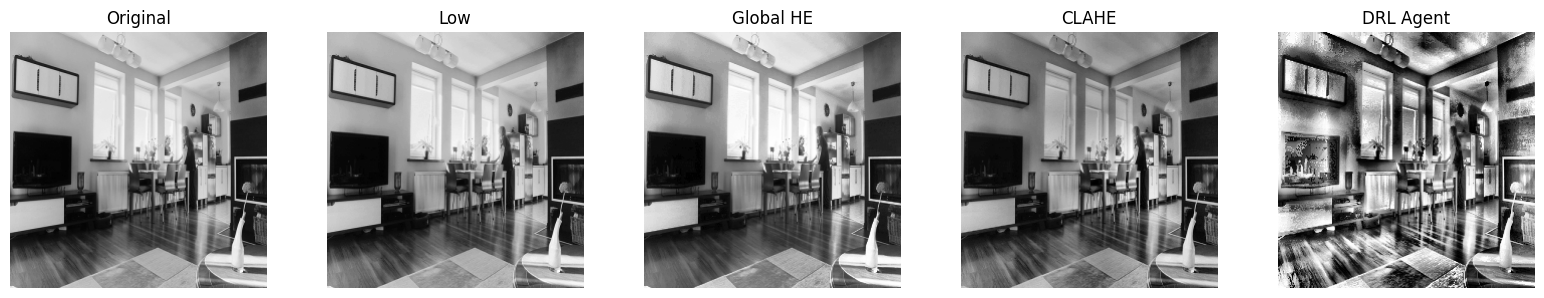

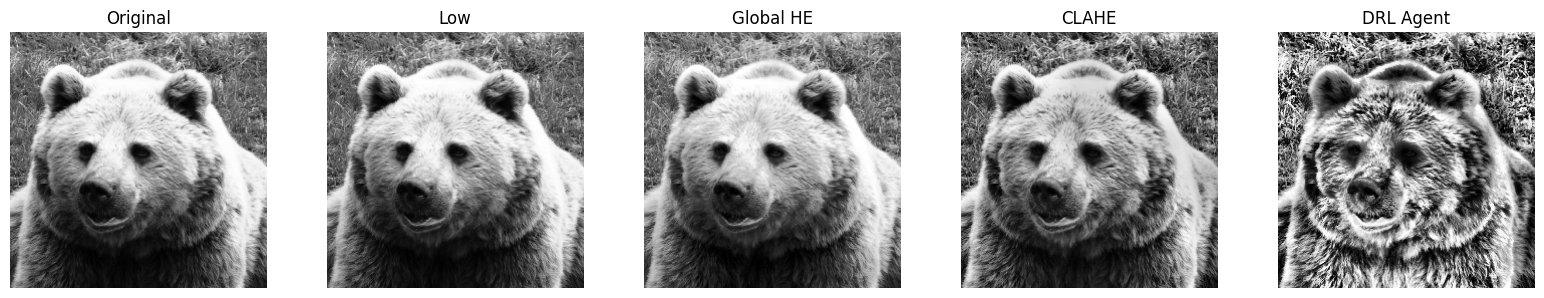

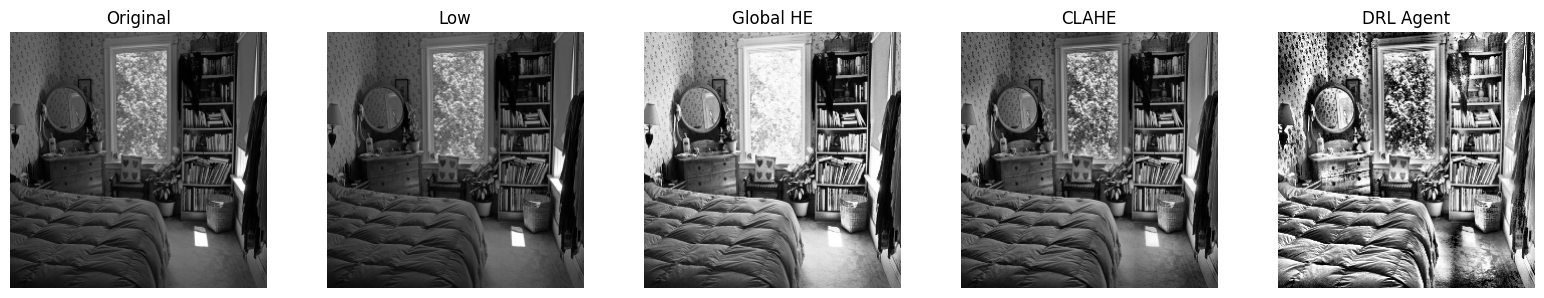

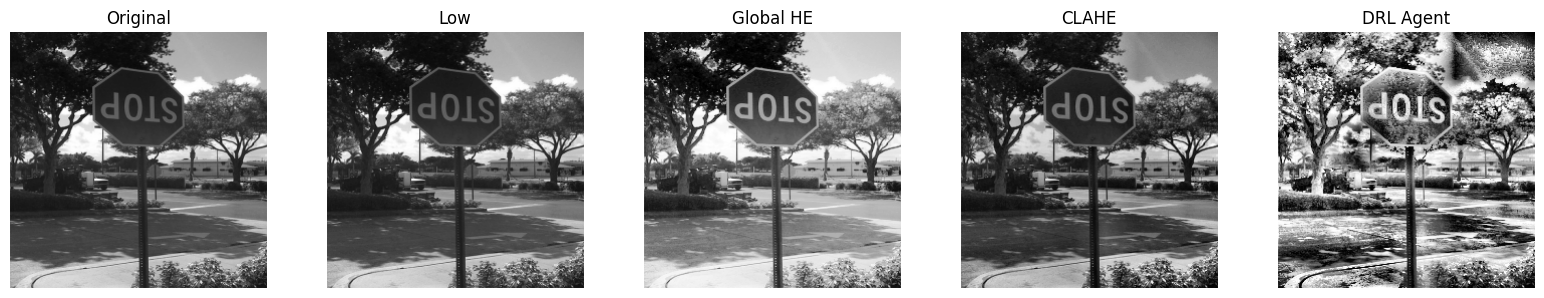

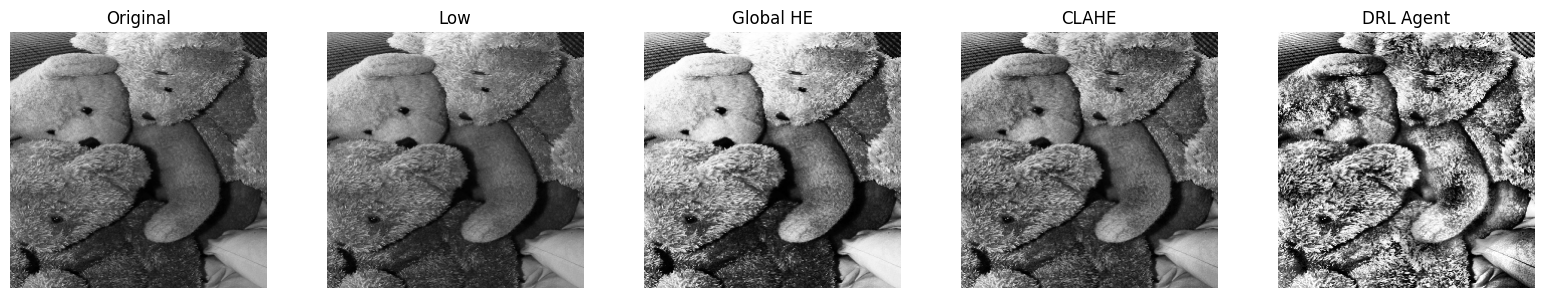

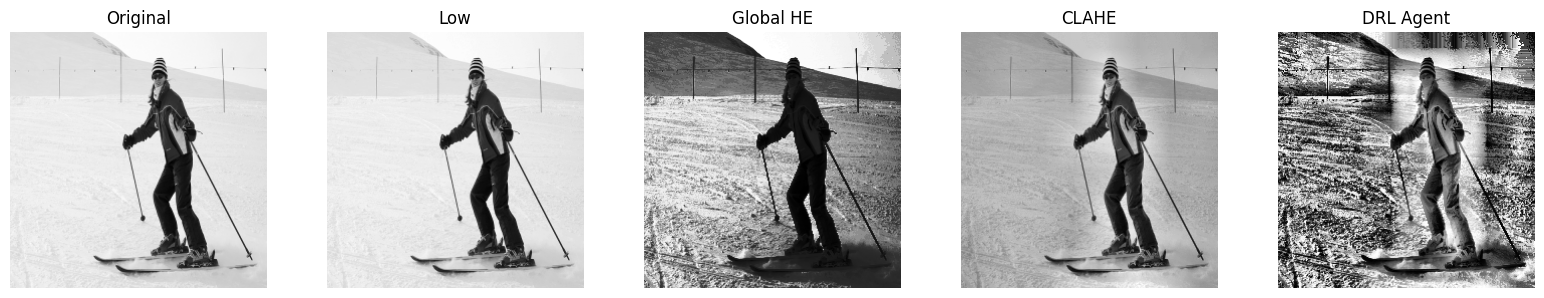

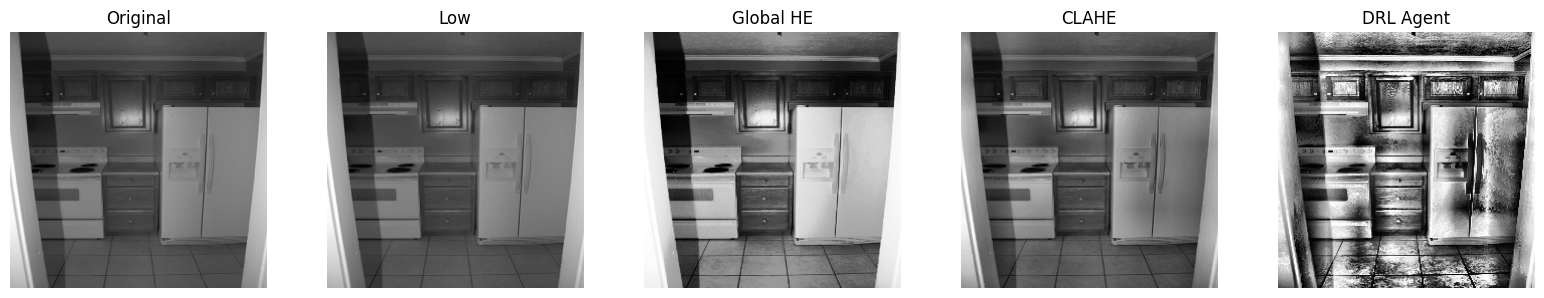

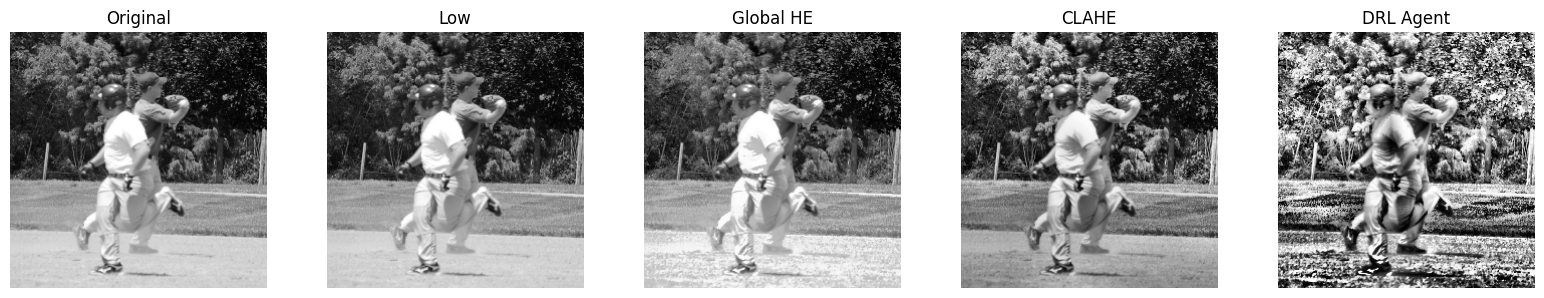

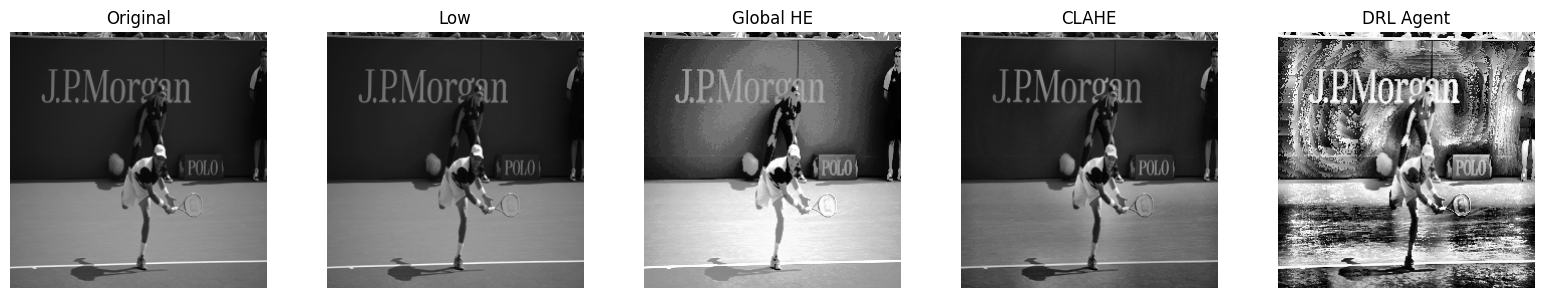

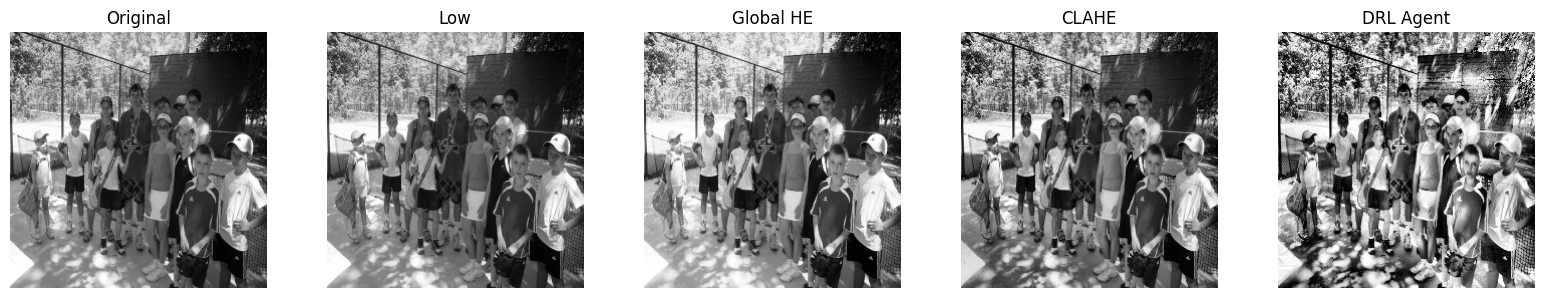

In [16]:

import matplotlib.pyplot as plt
if results:
  for i in range(len(results)):
    r = results[i]
    fig, axs = plt.subplots(1,5, figsize=(16,3))
    axs[0].imshow(r['orig'], cmap='gray');  axs[0].set_title('Original'); axs[0].axis('off')
    axs[1].imshow(r['low'], cmap='gray');   axs[1].set_title('Low'); axs[1].axis('off')
    axs[2].imshow(r['he'], cmap='gray');    axs[2].set_title('Global HE'); axs[2].axis('off')
    axs[3].imshow(r['clahe'], cmap='gray'); axs[3].set_title('CLAHE'); axs[3].axis('off')
    axs[4].imshow(r['agent'], cmap='gray'); axs[4].set_title('DRL Agent'); axs[4].axis('off')
    plt.tight_layout(); plt.show()
